In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
questions = []
expected = []
num = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    num = [f(),f()]
    num.sort()
    a = num[1]
    b = num[0]
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [8]:
print(questions[:5], expected[:5])

['76-7   ', '79-60  ', '88-9   ', '290-43 ', '63-29  '] ['69 ', '19 ', '79 ', '247', '34 ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS)

Vectorization...


In [10]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]
train_y = y[:20000]
test_x = x[20000:]
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 3, 12)
Validation Data:
(2000, 7, 12)
(2000, 3, 12)
Testing Data:
(60000, 7, 12)
(60000, 3, 12)


In [11]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False False False
    True]
  [False False False False  True False False False False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [False False  True False False False False False False False False
   False]
  [ True False False False False False False False False False False
   False]
  [ True False False False False False False False False False False
   False]]

 [[False False False False False False False False False  True False
   False]
  [False False False False False False False False False False False
    True]
  [False False False False  True False False False False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [False False False False False False Fal

# Build Model

In [12]:
print('Build model...')
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

############################################
##### Build your own model here ############
############################################
n_chars = len(chars)
# create LSTM
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

In [13]:
import matplotlib.pyplot as plt
training = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/200
18000/18000 [==============================] - 11s 588us/step - loss: 2.3341 - acc: 0.1296 - val_loss: 2.2826 - val_acc: 0.1378
Epoch 2/200
18000/18000 [==============================] - 5s 255us/step - loss: 2.2192 - acc: 0.1739 - val_loss: 2.1402 - val_acc: 0.1990
Epoch 3/200
18000/18000 [==============================] - 4s 248us/step - loss: 2.0604 - acc: 0.2360 - val_loss: 2.0188 - val_acc: 0.2480
Epoch 4/200
18000/18000 [==============================] - 5s 259us/step - loss: 1.9611 - acc: 0.2742 - val_loss: 1.9240 - val_acc: 0.2862
Epoch 5/200
18000/18000 [==============================] - 4s 248us/step - loss: 1.8972 - acc: 0.2973 - val_loss: 1.8610 - val_acc: 0.3023
Epoch 6/200
18000/18000 [==============================] - 5s 253us/step - loss: 1.8470 - acc: 0.3164 - val_loss: 1.8404 - val_acc: 0.3123
Epoch 7/200
18000/18000 [==============================] - 5s 260us/

18000/18000 [==============================] - 4s 227us/step - loss: 0.6530 - acc: 0.7667 - val_loss: 0.7062 - val_acc: 0.7222
Epoch 58/200
18000/18000 [==============================] - 4s 235us/step - loss: 0.6272 - acc: 0.7784 - val_loss: 0.6792 - val_acc: 0.7375
Epoch 59/200
18000/18000 [==============================] - 4s 245us/step - loss: 0.5967 - acc: 0.7896 - val_loss: 0.6617 - val_acc: 0.7448
Epoch 60/200
18000/18000 [==============================] - 4s 236us/step - loss: 0.5769 - acc: 0.7982 - val_loss: 0.6324 - val_acc: 0.7540
Epoch 61/200
18000/18000 [==============================] - 4s 232us/step - loss: 0.5459 - acc: 0.8118 - val_loss: 0.6065 - val_acc: 0.7688
Epoch 62/200
18000/18000 [==============================] - 4s 229us/step - loss: 0.5180 - acc: 0.8259 - val_loss: 0.5853 - val_acc: 0.7823
Epoch 63/200
18000/18000 [==============================] - 4s 237us/step - loss: 0.4947 - acc: 0.8357 - val_loss: 0.6077 - val_acc: 0.7617
Epoch 64/200
18000/18000 [=======

18000/18000 [==============================] - 5s 272us/step - loss: 0.0679 - acc: 0.9871 - val_loss: 0.1522 - val_acc: 0.9493
Epoch 116/200
18000/18000 [==============================] - 5s 274us/step - loss: 0.0689 - acc: 0.9853 - val_loss: 0.1819 - val_acc: 0.9342
Epoch 117/200
18000/18000 [==============================] - 5s 261us/step - loss: 0.0822 - acc: 0.9801 - val_loss: 0.1761 - val_acc: 0.9348
Epoch 118/200
18000/18000 [==============================] - 5s 252us/step - loss: 0.0926 - acc: 0.9751 - val_loss: 0.1958 - val_acc: 0.9308
Epoch 119/200
18000/18000 [==============================] - 5s 254us/step - loss: 0.0901 - acc: 0.9753 - val_loss: 0.1698 - val_acc: 0.9387
Epoch 120/200
18000/18000 [==============================] - 5s 255us/step - loss: 0.0701 - acc: 0.9839 - val_loss: 0.1619 - val_acc: 0.9443
Epoch 121/200
18000/18000 [==============================] - 5s 262us/step - loss: 0.0804 - acc: 0.9798 - val_loss: 0.1556 - val_acc: 0.9443
Epoch 122/200
18000/18000 [

18000/18000 [==============================] - 3s 180us/step - loss: 0.0182 - acc: 0.9982 - val_loss: 0.1104 - val_acc: 0.9602
Epoch 174/200
18000/18000 [==============================] - 4s 200us/step - loss: 0.0186 - acc: 0.9982 - val_loss: 0.1117 - val_acc: 0.9595
Epoch 175/200
18000/18000 [==============================] - 3s 194us/step - loss: 0.0188 - acc: 0.9979 - val_loss: 0.1342 - val_acc: 0.9543
Epoch 176/200
18000/18000 [==============================] - 3s 188us/step - loss: 0.1630 - acc: 0.9476 - val_loss: 0.2887 - val_acc: 0.9018
Epoch 177/200
18000/18000 [==============================] - 3s 192us/step - loss: 0.0779 - acc: 0.9756 - val_loss: 0.1581 - val_acc: 0.9452
Epoch 178/200
18000/18000 [==============================] - 3s 190us/step - loss: 0.0274 - acc: 0.9959 - val_loss: 0.1097 - val_acc: 0.9608
Epoch 179/200
18000/18000 [==============================] - 4s 204us/step - loss: 0.0182 - acc: 0.9984 - val_loss: 0.1074 - val_acc: 0.9613
Epoch 180/200
18000/18000 [

Text(0.5,1,'3 digits sub')

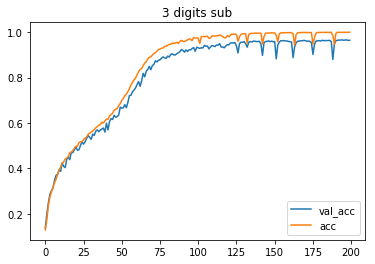

In [16]:
val_acc = training.history['val_acc']
acc = training.history['acc']
plt.figure()
plt.plot(val_acc, label = 'val_acc')
plt.plot(acc, label = 'acc')
plt.legend(loc='lower right')
plt.title('3 digits sub')

# Testing

In [17]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
#####################################################
correct_ct = 0
accuracy = 0
for i in range(len(test_x)):
    ind = np.random.randint(0, len(test_x))
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if correct == guess:
        correct_ct = correct_ct + 1
    else: 
        if i < 1000 :
            print(i, ' Q', q[::-1] if REVERSE else q, end=' ')
            print('T', correct, end=' ')
            print(colors.fail + '☒' + colors.close, end=' ')
            print(guess)
accuracy = correct_ct/len(test_x)
print('accu:', accuracy)




MSG : Prediction
2  Q 316-137 T 179 ☒ 189
16  Q 233-124 T 109 ☒ 108
19  Q 527-67  T 460 ☒ 450
20  Q 785-784 T 1   ☒ 8  
21  Q 39-33   T 6   ☒ 5  
49  Q 621-579 T 42  ☒ 32 
50  Q 209-85  T 124 ☒ 123
51  Q 144-121 T 23  ☒ 13 
74  Q 832-798 T 34  ☒ 44 
103  Q 716-555 T 161 ☒ 151
124  Q 46-44   T 2   ☒ 3  
130  Q 505-352 T 153 ☒ 143
139  Q 890-655 T 235 ☒ 335
153  Q 815-813 T 2   ☒ 7  
158  Q 960-598 T 362 ☒ 352
160  Q 25-21   T 4   ☒ 3  
185  Q 317-252 T 65  ☒ 55 
187  Q 984-885 T 99  ☒ 19 
194  Q 794-301 T 493 ☒ 483
201  Q 573-495 T 78  ☒ 88 
209  Q 681-130 T 551 ☒ 550
214  Q 958-942 T 16  ☒ 26 
224  Q 741-701 T 40  ☒ 30 
228  Q 704-529 T 175 ☒ 166
232  Q 401-166 T 235 ☒ 135
235  Q 803-10  T 793 ☒ 893
243  Q 788-691 T 97  ☒ 18 
263  Q 742-717 T 25  ☒ 24 
265  Q 192-3   T 189 ☒ 199
270  Q 850-160 T 690 ☒ 790
277  Q 26-26   T 0   ☒ 1  
285  Q 975-784 T 191 ☒ 290
288  Q 920-229 T 691 ☒ 791
300  Q 515-509 T 6   ☒ 4  
301  Q 924-865 T 59  ☒ 69 
303  Q 616-415 T 201 ☒ 101
307  Q 542-504 T 38  

accu: 0.8975666666666666


##### 